In [1]:
print('hello')

hello


In [2]:
import torch, numpy as np, matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)


device: cpu


In [3]:
# Affine transform parameters as tensors on device
A = torch.tensor([
    [0.00, 0.00, 0.00, 0.16, 0.00, 0.00],  # f1
    [0.85, 0.04,-0.04, 0.85, 0.00, 1.60],  # f2
    [0.20,-0.26, 0.23, 0.22, 0.00, 1.60],  # f3
    [-0.15,0.28, 0.26, 0.24, 0.00, 0.44],  # f4
], dtype=torch.float32, device=device)

p = torch.tensor([0.01, 0.85, 0.07, 0.07], dtype=torch.float32, device=device)
p_cum = torch.cumsum(p, dim=0)


In [4]:
# How many independent chains and iterations
n_chains   = 200_000
n_iters    = 50          # total points ≈ n_chains * n_iters
burn_in    = 5           # toss first few (stabilise)

# Start at origin for all chains
xy = torch.zeros(n_chains, 2, device=device)

xs, ys = [], []

for t in range(n_iters):
    # choose transform indices by probabilities (vectorised)
    u = torch.rand(n_chains, device=device).unsqueeze(1)  # (N,1)
    idx = (u > p_cum[:-1]).sum(dim=1)  # which bin u falls into (0..3)

    # gather parameters for chosen transforms
    a,b,c,d,e,f = (A[idx,0], A[idx,1], A[idx,2], A[idx,3], A[idx,4], A[idx,5])

    # apply affine transform
    x, y = xy[:,0], xy[:,1]
    x_new = a*x + b*y + e
    y_new = c*x + d*y + f
    xy = torch.stack([x_new, y_new], dim=1)

    if t >= burn_in:
        xs.append(x_new)
        ys.append(y_new)

# Concatenate collected points
X = torch.cat(xs)  # (n_points,)
Y = torch.cat(ys)
print("points:", X.numel())


points: 9000000


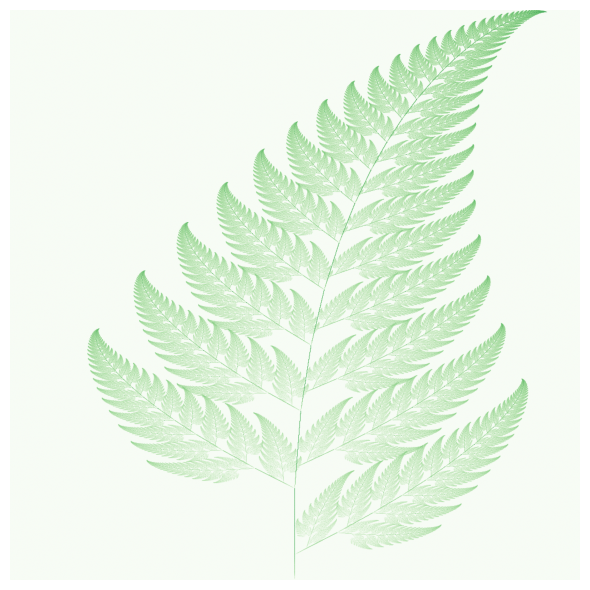

In [5]:
# Define plotting window & grid size
xmin, xmax = -3.0, 3.0
ymin, ymax =  0.0, 10.0
H = W = 1024

# map to pixel indices
ix = ((X - xmin) / (xmax - xmin) * (W-1)).clamp(0, W-1).long()
iy = ((ymax - Y) / (ymax - ymin) * (H-1)).clamp(0, H-1).long()  # flip y for image

# accumulate counts into an image with scatter_add
img = torch.zeros((H, W), dtype=torch.float32, device=device)
flat_idx = iy * W + ix
img = img.view(-1).scatter_add(0, flat_idx, torch.ones_like(flat_idx, dtype=torch.float32))
img = img.view(H, W)

# log contrast for visibility
viz = torch.log1p(img).detach().cpu().numpy()

plt.figure(figsize=(6,8))
plt.imshow(viz, cmap='Greens')
plt.axis('off'); plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
#AIUSE DESCRIPTION
def box_counting_dimension(binary, sizes=(16,32,64,128,256,512)):
    H, W = binary.shape
    Ns, inv_eps = [], []
    for s in sizes:
        # number of boxes per axis
        bx, by = W//s, H//s
        # reshape into (by, s, bx, s) and mark non-empty boxes
        B = binary[:by*s, :bx*s].reshape(by, s, bx, s)
        count = (B.sum(axis=(1,3)) > 0).sum()  # boxes with at least one point
        Ns.append(count)
        inv_eps.append(W/s)                     # 1/ε
    # linear fit: log N ≈ D * log(1/ε) + c
    coeffs = np.polyfit(np.log(inv_eps), np.log(Ns), 1)
    return coeffs[0], (np.array(inv_eps), np.array(Ns))

binary = (img.detach().cpu().numpy() > 0).astype(np.uint8)
D, (inv_eps, Ns) = box_counting_dimension(binary)
print("Box-counting dimension (approx):", round(float(D), 3))
